In [1]:
import os
import glob
import cv2
import json
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [2]:
DATASET_DIR = "_data/validation"

In [3]:
def extract_image_masks(directory):
    result = []
    annotation_file = glob.glob(f"{directory}/*.json")[0]
    coco = COCO(annotation_file)
    cat_ids = coco.getCatIds()
    for img_data in coco.imgs.values():
        img_file = os.path.join(directory, img_data['file_name'])
        img = cv2.imread(img_file)
        anns_ids = coco.getAnnIds(imgIds=img_data['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        anns.sort(key=lambda x: x["area"])
        masks = []
        for i, ann in enumerate(anns):
            ann_mask = coco.annToMask(ann)
            masks.append(ann_mask)
        result.append((img, masks))
    return result

In [4]:
image_masks = []
for directory in [file for file in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, file))]:
    print(f"Processing {directory}")
    image_masks += extract_image_masks(os.path.join(DATASET_DIR, directory))
print(f"Found {len(image_masks)}")

Processing train
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Processing valid
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Processing test
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 351


TypeError: list indices must be integers or slices, not tuple

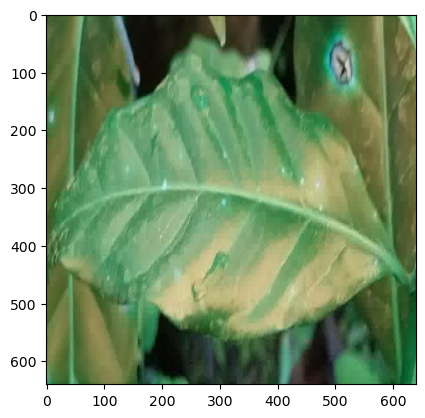

In [5]:
import random
image, mask = random.sample(image_masks, 1)[0]
plt.figure()
plt.imshow(image)
overlay = np.zeros(image.shape[:2] + (4,))
for val in np.unique(mask):
    if val == 0:
        continue
    binary_mask = mask[:, :, 0] == val
    overlay[binary_mask, :] = np.concatenate([np.random.random(3), [.5]])
ax = plt.gca()
ax.set_autoscale_on(False)
plt.imshow(overlay)
plt.show()

In [6]:
def get_patches(masks, image, apply_mask=False, padding=0):
    result = []
    
    for mask in masks:
        if apply_mask:
            image_tmp = image * (mask["segmentation"][:, :, np.newaxis])
        else:
            image_tmp = image
        
        bbox = mask["bbox"]
        x0 = bbox[1]-padding
        if x0 < 0:
            x0 = 0
        x1 = bbox[1]+bbox[3]+padding
        if x1 >= image.shape[0]:
            x1 = image.shape[0] - 1
        y0 = bbox[0]-padding
        if y0 < 0:
            y0 = 0
        y1 = bbox[0]+bbox[2]+padding
        if y1 >= image.shape[1]:
            y1 = image.shape[1] - 1
        
        patch = image_tmp[int(x0):int(x1), int(y0):int(y1)]
        
        if 0 in patch.shape:
            continue
        result.append(patch)
    
    return result

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights

In [8]:
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
class BinaryResnetClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryResnetClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = resnet50(ResNet50_Weights.IMAGENET1K_V1)  # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.resnet.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.resnet(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [10]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2),  # 112x112
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),  # 56x56
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),  # 28x28
            act_fn,
            nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),  # 14x14
            act_fn,
            nn.Conv2d(8*out_channels, 16*out_channels, 3, padding=1, stride=2),  # 7x7
            act_fn,
            nn.Flatten(),
            nn.Linear(16*out_channels*7*7, latent_dim),
            act_fn
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 16*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1),  # 14x14
            act_fn,
            nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1),  # 28x28
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1),  # 56x56
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1),  # 112x112
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1),  # 224x224
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 16*self.out_channels, 7, 7)
        output = self.conv(output)
        return output

#  defining autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, encoder=Encoder(), decoder=Decoder()):
        super().__init__()
        self.encoder = encoder
#        self.encoder.to(device)

        self.decoder = decoder
#        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [46]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from ultralytics import YOLO
import torchvision.transforms.v2 as transforms

yolo = YOLO("out/yolo_urban_street/train/weights/best.pt")

resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")
resnet = resnet.to(device)
resnet.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomAffine(180, shear=45),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])


autoencoder = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")
autoencoder.eval()

autoencoder_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

def predict_sam(img, pred, apply_mask=False):
    masks = mask_generator.generate(img)
    masks.sort(key=lambda x: x["area"])
    patches = get_patches(masks, img, apply_mask)
    result = []
    
    for i, (mask, patch) in enumerate(zip(masks, patches)):
        if pred(patch):
            result.append(mask["segmentation"] > 0)
    return result
    
def prep_img(img):
    return torch.Tensor(img).to(device).permute(2, 0, 1).unsqueeze(0)

def predict_sam_autoencoder(img):
    def pred(x):
        x = autoencoder_transform(prep_img(x))
        gt = autoencoder_transform(prep_img(img
                                           ))
        with torch.no_grad():
            val = torch.sigmoid(nn.MSELoss()(autoencoder(x), gt)).item()
            return val < .75
    return predict_sam(img, pred, True)
    
def predict_sam_resnet(img):
    def pred(x):
        x = resnet_transform(prep_img(x))
        with torch.no_grad():
            return resnet(x).item() > .5
    return predict_sam(img, pred)
    
def predict_sam_yolo(img):
    return predict_sam(img, lambda x: yolo.predict(x)[0].masks is not None)
    
def predict_yolo(image):
    result = yolo.predict(image)[0].masks
    if result is None:
        return np.zeros(image.shape[:2])
    return result.data.cpu().numpy()

In [47]:
prediction_dict = {
    "YOLOv8": predict_yolo,
    "SAM + ResNet": predict_sam_resnet,
    "SAM + Autoencoder": predict_sam_autoencoder,
    "SAM + YOLOv8": predict_sam_yolo,
}

In [33]:
%matplotlib inline
def compare_segmentation_masks(mask1, mask2, img):
    # Ensure that both masks are binary and of the same shape
    assert mask1.shape == mask2.shape, "Masks must have the same shape"
    
    # Create a figure and clear any previous plots
    plt.figure(figsize=(10, 5))
    plt.clf()  # Clear the figure to overwrite the previous one

    # Plot the first mask
    plt.subplot(1, 4, 1)
    plt.title('Mask 1')
    plt.imshow(mask1, cmap='gray')
    plt.axis('off')

    # Plot the second mask
    plt.subplot(1, 4, 2)
    plt.title('Mask 2')
    plt.imshow(mask2, cmap='gray')
    plt.axis('off')

    # Create a difference mask (where masks disagree)
    difference_mask = (mask1 != mask2).astype(np.float32)

    # Plot the difference between the two masks
    plt.subplot(1, 4, 3)
    plt.title('Difference (Mask1 != Mask2)')
    plt.imshow(difference_mask, cmap='Reds')
    plt.axis('off')
    
    plt.subplot(1, 4, 4) # Plot the difference between the two masks
    plt.title('Image')
    plt.imshow(img)
    plt.axis('off')

    # Show the comparison
    plt.tight_layout()
    plt.show()

In [34]:
import pandas as pd

In [35]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    return intersection / union

# Function to calculate Dice coefficient between two masks
def dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    sum_areas = mask1.sum() + mask2.sum()
    if sum_areas == 0:
        return 0
    return 2 * intersection / sum_areas

In [36]:
from scipy.optimize import linear_sum_assignment

def match_masks(pred_masks, gt_masks, iou_threshold=0.5):
    iou_matrix = np.zeros((len(pred_masks), len(gt_masks)))

    # Calculate IoU for each pair of predicted and ground truth masks
    for i, pred in enumerate(pred_masks):
        for j, gt in enumerate(gt_masks):
            iou_matrix[i, j] = iou(pred, gt)

    # Use Hungarian algorithm for optimal matching
    pred_indices, gt_indices = linear_sum_assignment(-iou_matrix)

    # True Positives (TP), False Positives (FP), False Negatives (FN)
    tp = 0
    fp = 0
    fn = 0
    matched_pairs = []
    iou_scores = []
    dice_scores = []

    for i, j in zip(pred_indices, gt_indices):
        if iou_matrix[i, j] >= iou_threshold:
            tp += 1
            matched_pairs.append((i, j))  # Store matched pairs for further analysis
            iou_scores.append(iou_matrix[i, j])  # IoU for this matched pair
            dice_scores.append(dice(pred_masks[i], gt_masks[j]))  # Dice for this matched pair
        else:
            fp += 1

    fn = len(gt_masks) - tp  # Unmatched ground truth masks are false negatives
    fp += len(pred_masks) - tp  # Unmatched predicted masks are false positives

    return tp, fp, fn, matched_pairs, iou_scores, dice_scores

In [37]:
def compute_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

In [38]:
def evaluate_instance_segmentation(gt_masks, pred_masks, iou_threshold=0.5):
    tp, fp, fn, matched_pairs, iou_scores, dice_scores = match_masks(pred_masks, gt_masks, iou_threshold)
    precision, recall, f1_score = compute_metrics(tp, fp, fn)
    
    # Calculate mean IoU and mean Dice score
    mean_iou = np.mean(iou_scores) if iou_scores else 0
    mean_dice = np.mean(dice_scores) if dice_scores else 0
    
    return {
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "mean_iou": mean_iou,
        "mean_dice": mean_dice,
        #"matched_pairs": matched_pairs,
    }

In [48]:
results = dict()
result_dfs = dict()
for name, func in prediction_dict.items():
    df = pd.DataFrame()
    result = []
    for img, gt_masks in tqdm(image_masks, desc=f"Evaluating {name}"):
        pred_masks = func(img)
        eval_results = evaluate_instance_segmentation(gt_masks, pred_masks)
        df = pd.concat([df, pd.DataFrame(eval_results, index=range(len(eval_results)))], ignore_index=True)
        result.append(eval_results)
    results[name] = result
    result_dfs[name] = df
    df.to_csv(f"out/validation/{name}.csv")

Evaluating YOLOv8:   0%|          | 0/351 [00:00<?, ?it/s]


0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   0%|          | 1/351 [00:00<01:28,  3.96it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   2%|▏         | 7/351 [00:01<00:48,  7.09it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   4%|▎         | 13/351 [00:01<00:24, 13.94it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   5%|▌         | 19/351 [00:01<00:15, 21.08it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   7%|▋         | 25/351 [00:01<00:11, 28.08it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:   9%|▉         | 32/351 [00:01<00:08, 35.63it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  11%|█         | 38/351 [00:01<00:11, 27.59it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  12%|█▏        | 43/351 [00:02<00:21, 14.54it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  14%|█▍        | 49/351 [00:02<00:15, 18.97it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  15%|█▌        | 53/351 [00:02<00:17, 17.18it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  16%|█▌        | 56/351 [00:03<00:19, 15.49it/s]


0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  18%|█▊        | 62/351 [00:03<00:13, 21.15it/s]


0: 640x640 1 leaf, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  19%|█▉        | 67/351 [00:03<00:14, 19.52it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  21%|██        | 73/351 [00:03<00:10, 25.37it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  23%|██▎       | 79/351 [00:03<00:08, 31.24it/s]


0: 640x640 1 leaf, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.9ms
Speed: 1.7ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  24%|██▍       | 84/351 [00:03<00:07, 34.04it/s]


0: 640x640 1 leaf, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.6ms
Speed: 1.6ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  26%|██▌       | 90/351 [00:04<00:06, 38.22it/s]


0: 640x640 1 leaf, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.5ms
Speed: 1.7ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 13.2ms
Speed: 1.7ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  27%|██▋       | 95/351 [00:04<00:06, 39.76it/s]


0: 640x640 1 leaf, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 12.6ms
Speed: 1.7ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  28%|██▊       | 100/351 [00:04<00:06, 40.44it/s]


0: 640x640 1 leaf, 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 1.6ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  30%|███       | 106/351 [00:04<00:05, 43.68it/s]


0: 640x640 1 leaf, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  32%|███▏      | 111/351 [00:05<00:20, 11.73it/s]


0: 640x640 1 leaf, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  33%|███▎      | 117/351 [00:05<00:14, 15.85it/s]


0: 640x640 2 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  35%|███▌      | 123/351 [00:05<00:11, 20.44it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 13.0ms
Speed: 1.7ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  36%|███▋      | 128/351 [00:05<00:09, 24.08it/s]


0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  38%|███▊      | 133/351 [00:06<00:10, 21.07it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  40%|███▉      | 139/351 [00:06<00:08, 26.50it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  41%|████      | 144/351 [00:06<00:09, 22.75it/s]


0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  43%|████▎     | 151/351 [00:06<00:06, 29.33it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.8ms
Speed: 1.6ms preprocess, 12.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  45%|████▍     | 157/351 [00:06<00:05, 33.54it/s]


0: 640x640 1 leaf, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  46%|████▌     | 162/351 [00:07<00:09, 20.13it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  48%|████▊     | 168/351 [00:07<00:11, 15.90it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  50%|████▉     | 174/351 [00:08<00:08, 20.48it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  51%|█████▏    | 180/351 [00:08<00:06, 25.61it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  53%|█████▎    | 185/351 [00:08<00:09, 17.61it/s]


0: 640x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  54%|█████▍    | 189/351 [00:09<00:12, 13.13it/s]


0: 640x640 1 leaf, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  55%|█████▌    | 194/351 [00:09<00:09, 16.66it/s]


0: 640x640 1 leaf, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  57%|█████▋    | 200/351 [00:09<00:06, 21.96it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  59%|█████▊    | 206/351 [00:09<00:05, 27.60it/s]


0: 640x640 1 leaf, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  60%|██████    | 212/351 [00:09<00:04, 32.91it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 12.1ms
Speed: 1.6ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  62%|██████▏   | 217/351 [00:10<00:07, 18.40it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.6ms
Speed: 1.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  64%|██████▎   | 223/351 [00:10<00:05, 23.62it/s]


0: 640x640 1 leaf, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  65%|██████▌   | 229/351 [00:11<00:08, 14.17it/s]


0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  67%|██████▋   | 235/351 [00:11<00:06, 18.54it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  69%|██████▉   | 242/351 [00:11<00:04, 24.18it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  71%|███████   | 248/351 [00:11<00:03, 29.24it/s]


0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  72%|███████▏  | 254/351 [00:11<00:02, 34.32it/s]


0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  74%|███████▍  | 260/351 [00:12<00:04, 20.67it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  76%|███████▌  | 267/351 [00:12<00:03, 26.43it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  78%|███████▊  | 274/351 [00:12<00:02, 32.29it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  80%|███████▉  | 280/351 [00:12<00:01, 36.69it/s]


0: 640x640 1 leaf, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  81%|████████▏ | 286/351 [00:12<00:01, 41.07it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  83%|████████▎ | 292/351 [00:12<00:01, 44.83it/s]


0: 640x640 1 leaf, 12.6ms
Speed: 1.7ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 leafs, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  85%|████████▍ | 298/351 [00:13<00:02, 18.58it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.5ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  86%|████████▋ | 303/351 [00:14<00:03, 14.69it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  88%|████████▊ | 310/351 [00:14<00:02, 19.82it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  90%|█████████ | 317/351 [00:14<00:01, 25.37it/s]


0: 640x640 1 leaf, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  92%|█████████▏| 323/351 [00:14<00:00, 30.35it/s]


0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.7ms
Speed: 1.7ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  94%|█████████▎| 329/351 [00:14<00:00, 34.20it/s]


0: 640x640 1 leaf, 10.3ms
Speed: 1.6ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  95%|█████████▌| 334/351 [00:14<00:00, 25.62it/s]


0: 640x640 1 leaf, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 9.4ms
Speed: 1.7ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.5ms
Speed: 1.7ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  97%|█████████▋| 340/351 [00:14<00:00, 29.97it/s]


0: 640x640 1 leaf, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.6ms
Speed: 1.8ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating YOLOv8:  98%|█████████▊| 345/351 [00:15<00:00, 17.64it/s]


0: 640x640 1 leaf, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.3ms
Speed: 1.6ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 leaf, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating SAM + ResNet:   0%|          | 0/351 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [56]:
METRICS = ["true_positives", "false_positives", "false_negatives", "precision", "recall", "f1_score", "mean_iou", "mean_dice"]
csv_files = [file for file in os.listdir("out/validation") if file.endswith(".csv")]
result_dfs = dict()
for file in csv_files:
    name = file.replace(".csv", "")
    df = pd.read_csv(os.path.join("out/validation", file), usecols=METRICS)
    result_dfs[name] = df

In [57]:
# Step 1: Calculate the mean of each DataFrame
mean_values = {key: df.mean() for key, df in result_dfs.items()}

# Step 2: Convert the dictionary to a DataFrame
mean_df = pd.DataFrame(mean_values).T  # Transpose for better visualization

# Step 3: Melt the DataFrame for seaborn
mean_df_melted = mean_df.reset_index().melt(id_vars='index', 
                                            var_name='Metric', 
                                            value_name='Mean Value')
mean_df_melted.rename(columns={'index': 'DataFrame'}, inplace=True)

mean_df_melted

,DataFrame,Metric,Mean Value
0,YOLOv8,true_positives,0.578348
1,SAM + ResNet,true_positives,1.207977
2,SAM + Autoencoder,true_positives,0.000000
3,SAM + YOLOv8,true_positives,1.133903
4,YOLOv8,false_positives,39.205128
5,SAM + ResNet,false_positives,41.401709
6,SAM + Autoencoder,false_positives,0.000000
7,SAM + YOLOv8,false_positives,20.831909
8,YOLOv8,false_negatives,0.846154
9,SAM + ResNet,false_negatives,0.216524


In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(mean_df), columns=mean_df.columns, index=mean_df.index)

# Step 4: Melt the DataFrame for seaborn
scaled_df_melted = scaled_df.reset_index().melt(id_vars='index', 
                                                var_name='Metric', 
                                                value_name='Scaled Value')
scaled_df_melted.rename(columns={'index': 'DataFrame'}, inplace=True)

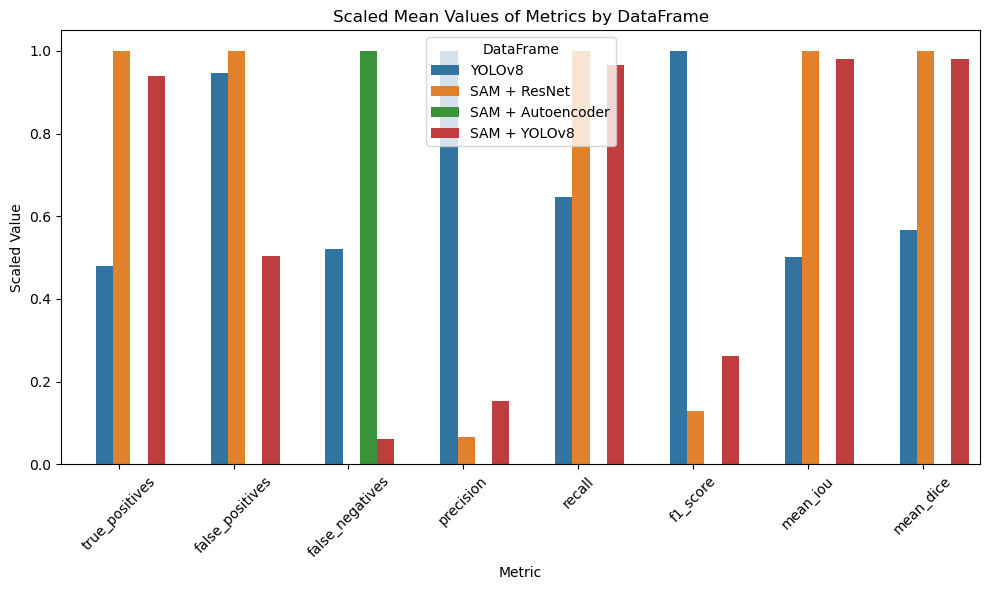

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Scaled Value', hue='DataFrame', data=scaled_df_melted, dodge=True, width=0.6)

# Adjust the spacing between bar groups
ax = plt.gca()
for patch in ax.patches:
    patch.set_x(patch.get_x() + 0.1)  # Increase this value to add more space between groups

plt.title('Scaled Mean Values of Metrics by DataFrame')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()